NOTE: This analysis is ongoing.  Check back again soon for more coffee insights!

# The Caffeine Supply Chain: A Coffee Market Analysis

What does the global coffee market actually look like?  Who are the major players?  We will attempt to answer some of those questions.

---

<br>[Setup](setup.ipynb) (Create your own PostgreSQL database with ICO coffee data for your own analysis)

# Coffee Growing

Coffee drinking is a global pastime, and its drinking population is growing.  In the U.S. alone, over 200 million people regularly drink an average of 3 cups of coffee per day <sup>1</sup>.  Over \\$225 Billion is spent on coffee in the United States, with consumers paying \\$75 Billion to consume coffee and nearly all of the other \\$150 Billion spent on the coffee supply chain.<sup>2</sup>

Most of the world's coffee is produced between the Tropics of Cancer and Capricorn (about 23.4 degrees north/south latitude), which are the farthest points north and south of the equator where the sun can appear directly overhead.  This region is able to receive the most energy from the sun and also holds climates with many of the attributes ideal for coffee growing like "a rich soil, mild temperatures, lots of rain, a dry season, and shaded sun"<sup>3</sup>.

This region is known as the coffee belt<sup>4</sup>:
![Coffee Belt](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Bean_belt_%28top_20_coffee_producers_2011%29.svg/800px-Bean_belt_%28top_20_coffee_producers_2011%29.svg.png)

<br><sup>1</sup> https://nationalcoffee.blog/2018/09/26/by-the-numbers-us-coffee-consumption/
<br><sup>2</sup> http://www.ncausa.org/industry-resources/economic-impact
<br><sup>3</sup> https://www.deathwishcoffee.com/blogs/news/what-is-the-coffee-belt
<br><sup>4</sup> https://en.wikipedia.org/wiki/Coffee_bean

NOTE: If you worked through the [Setup tutorial](setup.ipynb) we used standard Python in scripts to import our data and then some basic SQL to inspect the data for accuracy.  In most of the remaining analyses, we will use Python in this IPython environment to call our SQL queries so that we can utilize other Python analysis tools.  We will use the `connect` file methods to set up our queries so we do not need to repeat unnecessary code in this notebook.

In [140]:
import sys
sys.path.append('../')
import pandas as pd
from matplotlib import pyplot as plt
from src import connect
conn = connect.connect()
colors = ["#557d90","#44a797","#d96033","#5a463a","#426170","#d7c6b7"]
colors_dark = ["#296b80","#80a999","#6c8e81","#d7c6b7","#c67f4f","#18404C"]
vcolors_gray = ["#EAEAEA","#797979","#4E4B4C","#262626","#231F20"]
vcolors_bright = ["#6EB51C","#589016","#F73772"]
colors_exporters = colors_dark[:2] + colors_dark[3:]
colors_importers = colors_dark[:1] + colors_dark[2:]

# Create a method to handle real values for pie charts
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

## Coffee Market Overview

Most of the [20+ Billion lbs. of yearly coffee](https://apps.fas.usda.gov/psdonline/circulars/coffee.pdf) in the world comes from a few countries, with Brazil leading the pack:

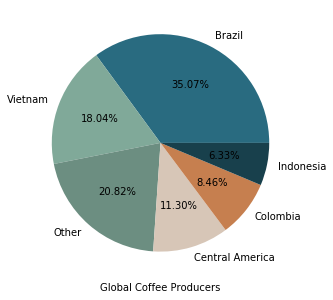

In [175]:
regions=['Brazil','Vietnam','Other','Central America','Colombia','Indonesia']
production=[59.3,30.5,35.2,19.1,14.3,10.7]
df = pd.DataFrame(production, index=regions, columns=[''])
p = df.plot.pie(y='', figsize=(5, 5), autopct="%.2f%%", colors=colors_dark)
p.get_legend().remove()
l = p.set_xlabel("Global Coffee Producers")

The United States does not produce coffee other than some small farms in Texas and California mostly engaged in research projects.  However, the consumer coffee market is very large in the U.S. with around [$225 Billion dollars spent](http://www.ncausa.org/industry-resources/economic-impact) on coffee from the supply chain to coffee beans and accessories:

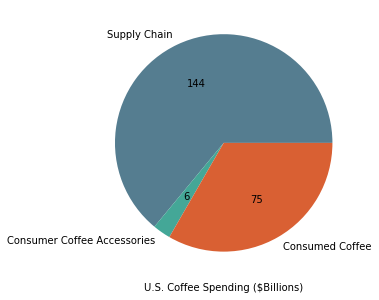

In [179]:
titles=['Supply Chain','Consumer Coffee Accessories','Consumed Coffee']
spending=[144,6,75]
df = pd.DataFrame(spending, index=titles, columns=[''])
p = df.plot.pie(y='', figsize=(5, 5), autopct=make_autopct(spending), colors=colors)
p.get_legend().remove()
l = p.set_xlabel("U.S. Coffee Spending ($Billions)")

Using [2018 statistics](https://nationalcoffee.blog/2018/09/26/by-the-numbers-us-coffee-consumption/) and making the conservative assumption that all out-of-home coffee drinkers are drinking gourmet coffee, we can calculate that at-home gourmet coffee drinkers in the U.S. total at least 55 million people (a low estimate):

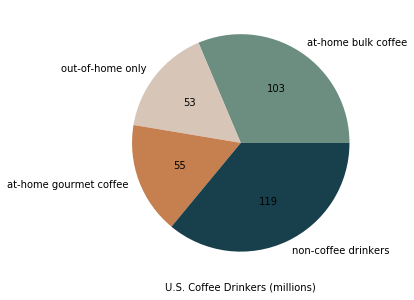

In [180]:
titles=['at-home bulk coffee','out-of-home only','at-home gourmet coffee','non-coffee drinkers']
spending=[103.5,52.8,54.9,118.8]
df = pd.DataFrame(spending, index=titles, columns=[''])
p = df.plot.pie(y='', figsize=(5, 5), autopct=make_autopct(spending), colors=colors_dark[2:])
p.get_legend().remove()
l = p.set_xlabel("U.S. Coffee Drinkers (millions)")

That is a lot of coffee drinkers, and that's only in the United States!  Now that we have an overview of the coffee market, let's look a bit closer at the coffee supply chain.

## Analysis

In the real world, data collection is hard and comprehensive data collection is nearly impossible, so let's take a high-level look at some data from the ICO (International Coffee Organization) and see if we have a complete picture of the supply chain before we dig into the details.  It is likely that we have some "holes" in our data and will need to make some assumptions to analyze the market as a whole.

## Supply Chain Measurement Variance

In a supply chain, the [inventory] + [inputs] - [outputs] should = the next cycle's [inventory].  If not, we should take note of the discrepancy to be sure it does not affect any analysis method.

That said, in the real world measurement variances and tolerated losses will always result in slight discrepancies.  If the calculated inventory ever matches the reported inventory, this is a sign that the data somewhere was not measured, but instead was calculated.

Every industry and company will have a standard for accepted variances in measurement and should conduct investigations when losses (or gains) exceed that standard tolerance range.

## Producers

Let's first examine the top coffee producing countries and regions to understand the source of the coffee supply chain.

To ensure our figures are accurate, before we start our analysis we will check aggregate numbers.  Let's query the sum of production in 2018.

In [22]:
df = pd.read_sql("""SELECT SUM(p.value) AS production
FROM seasonal_production p
INNER JOIN
    (
        SELECT l.id, l.title AS location, lg.title AS group  
        FROM location l
        INNER JOIN location_group lg ON l.id=lg.location_id
    ) AS loc
ON p.location_id=loc.id
WHERE year=2018;""",conn)
x = df.at[0,'production']
print(f'{x:,.0f}')

158,074


The production figure `158,074` matches the 2017/18 Crop year production in the ICO Excel file (column AD, row 68).  If we wanted to check a few other years, we should also see that the production file matches our database data.

Now that we know our database correctly imported data, let's take a look at all production by our assigned groups (see [Setup](setup.ipynb) for group details).

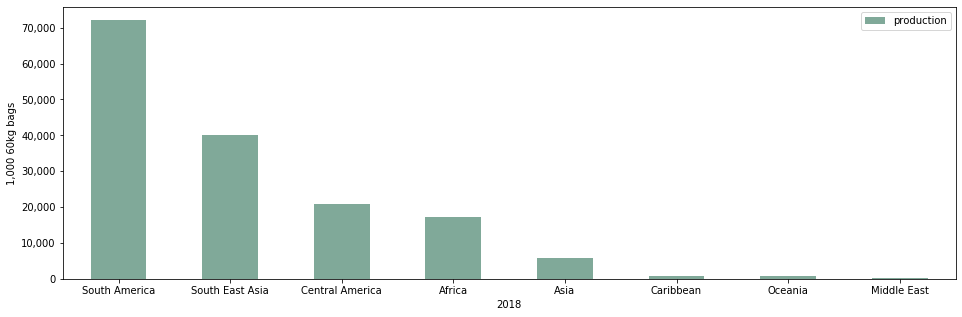

In [45]:
df = pd.read_sql("""SELECT loc.group, SUM(p.value) AS production
FROM seasonal_production p
INNER JOIN
    (
        SELECT l.id, l.title AS location, lg.title AS group  
        FROM location l
        INNER JOIN location_group lg ON l.id=lg.location_id
    ) AS loc
ON p.location_id=loc.id
WHERE year=2018
GROUP BY loc.group
ORDER BY production DESC;""",conn)
b = df.plot.bar(figsize=(16,5), color=colors_exporters[1])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['group'].tolist(), rotation=0)
b.set_ylabel("1,000 60kg bags")
l = b.set_xlabel("2018")

These measurements are all in units of 1,000 60kg. bags, so let's convert everything to US tons for now.

60,000 kgs. = 66.138679 tons

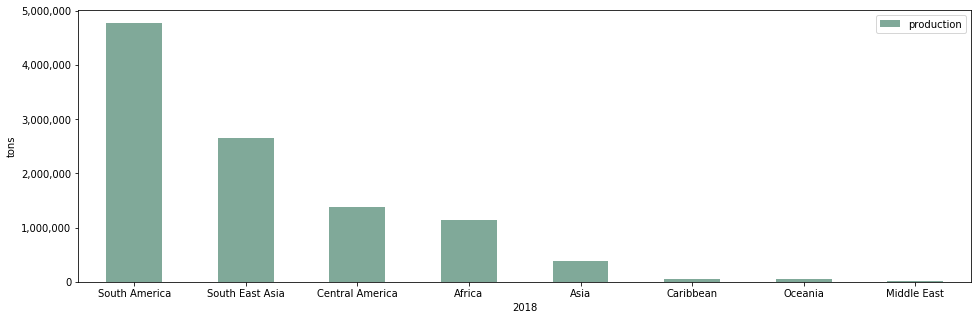

In [44]:
df = pd.read_sql("""SELECT loc.group, SUM(p.value * 66.138679) AS production
FROM seasonal_production p
INNER JOIN
    (
        SELECT l.id, l.title AS location, lg.title AS group  
        FROM location l
        INNER JOIN location_group lg ON l.id=lg.location_id
    ) AS loc
ON p.location_id=loc.id
WHERE year=2018
GROUP BY loc.group
ORDER BY production DESC;""",conn)
b = df.plot.bar(figsize=(16,5), color=colors_exporters[1])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['group'].tolist(), rotation=0)
b.set_ylabel("tons")
l = b.set_xlabel("2018")

South America is the highest producing group, so we will examine the details of that region.

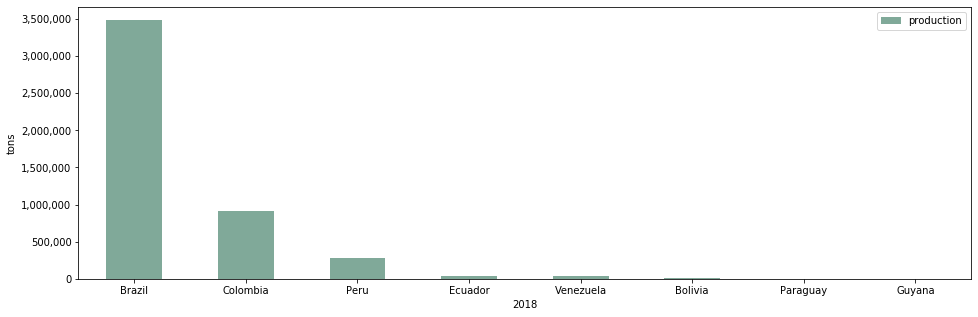

In [50]:
df = pd.read_sql("""SELECT loc.location, p.value * 66.138679 AS production
FROM seasonal_production p
INNER JOIN
    (
        SELECT l.id, l.title AS location, lg.title AS group  
        FROM location l
        INNER JOIN location_group lg ON l.id=lg.location_id
    ) AS loc
ON p.location_id=loc.id
WHERE year=2018 AND loc.group='South America'
ORDER BY production DESC;""",conn)
b = df.plot.bar(figsize=(16,5), color=colors_exporters[1])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['location'].tolist(), rotation=0)
b.set_ylabel("tons")
l = b.set_xlabel("2018")

Brazil not only leads production in South America, but is also the leading producer in the world, so we will dig in to their production as an example to better understand the components of the supply chain coming out of countries that grow coffee.

Before we begin, we need to check the consistency of our data, so we should examine the entire supply cycle (starting [inventory] + [inputs] - [outputs] = ending [inventory]) and compare calculated ending inventory to reported beginning inventory.  The [ICO data source](http://www.ico.org/new_historical.asp?section=Statistics) shows that exporter data records inventory as "opening stocks", so this calculation check should work.

To conduct this check, we will query the needed data and subtract our calculated ending inventory from the next season's reported beginning inventory.  Let's filter for only locations / years that include discrepancies above ~25,000 tons:

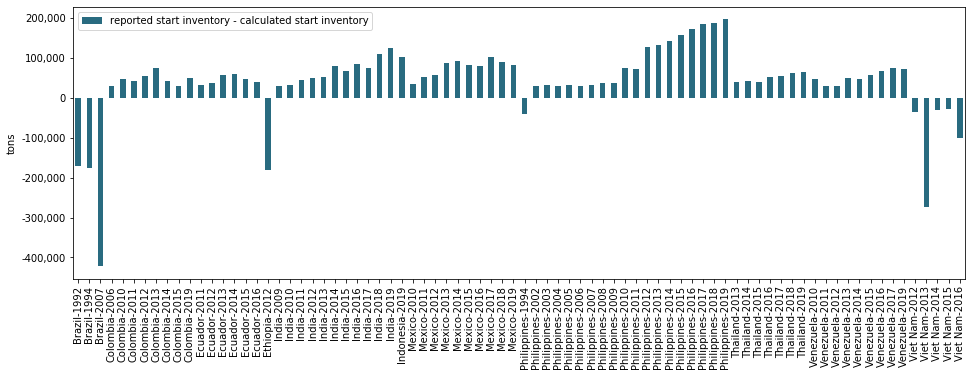

In [95]:
df = pd.read_sql("""SELECT CONCAT(l.title,'-',inv.year) AS location, (inv.value - (s3.inventory + s3.production + s3.exports + s3.consumption)) * 66.138679 AS "reported start inventory - calculated start inventory"
FROM location l 
INNER JOIN
    (
        SELECT c.location_id, c.year, s2.inventory, s2.production, s2.exports, 
            CASE 
                WHEN c.value > 0 THEN c.value * -1 
            END AS consumption 
        FROM seasonal_consumption c 
        INNER JOIN
            (
                SELECT i.location_id, i.year, i.value as inventory, s1.production, s1.exports 
                FROM seasonal_inventory i 
                INNER JOIN
                    (
                        SELECT p.location_id, p.year, p.value AS production,  
                            CASE  
                                WHEN e.value > 0 THEN e.value * -1 
                            END AS exports 
                        FROM seasonal_production p 
                        INNER JOIN seasonal_exports e ON p.location_id=e.location_id AND p.year=e.year
                    ) AS s1
                ON s1.location_id=i.location_id AND i.year=s1.year
            ) AS s2
        ON s2.location_id=c.location_id AND c.year=s2.year
    ) AS s3
ON s3.location_id=l.id
INNER JOIN seasonal_inventory inv ON inv.location_id=s3.location_id AND inv.year=s3.year+1
WHERE ((inv.value - (s3.inventory + s3.production + s3.exports + s3.consumption))>400 OR (inv.value - (s3.inventory + s3.production + s3.exports + s3.consumption))<-400)
ORDER BY l.title ASC, inv.year ASC;""",conn)
b = df.plot.bar(figsize=(16,5), color=colors_exporters[0])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['location'].tolist(), rotation=90)
l = b.set_ylabel("tons")

It appears that our discrepancies are limited to a few locations, although some of those locations consistently report discrepancies, so we need to consider that if we decide to examine these locations' data more closely.

We already decided to examine Brazil's data, so we should take note that in 1992, 1994, and 2007 there was a loss of inventory between the end of one season and the beginning of another.  Perhaps this was due to a reporting error or damaged inventories, we are not sure from the information we have here.

Let's go ahead and chart Brazilian data for recent years and show all of the supply chain components:

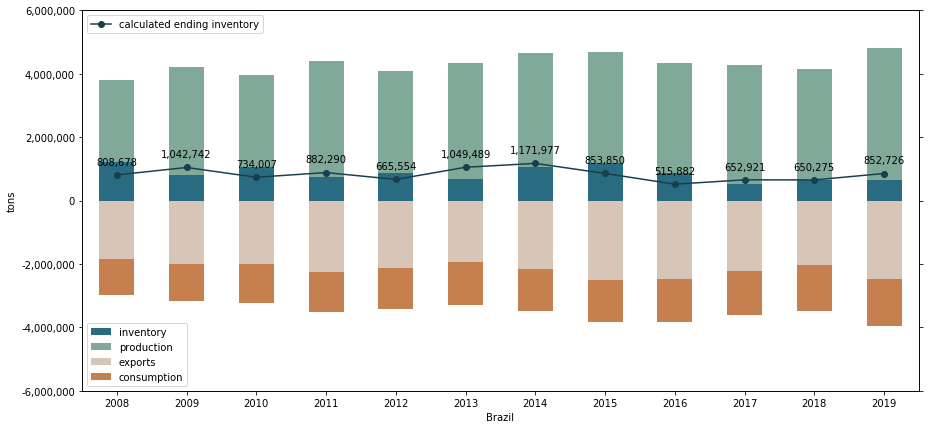

In [104]:
df = pd.read_sql("""SELECT l.title, s3.year, s3.inventory * 66.138679 AS inventory, s3.production * 66.138679 AS production, s3.exports * 66.138679 AS exports, s3.consumption * 66.138679 AS consumption, (s3.inventory + s3.production + s3.exports + s3.consumption) * 66.138679 AS "calculated ending inventory"
FROM location l 
INNER JOIN
    (
        SELECT c.location_id, c.year, s2.inventory, s2.production, s2.exports, 
            CASE 
                WHEN c.value > 0 THEN c.value * -1 
            END AS consumption 
        FROM seasonal_consumption c 
        INNER JOIN
            (
                SELECT i.location_id, i.year, i.value as inventory, s1.production, s1.exports 
                FROM seasonal_inventory i 
                INNER JOIN
                    (
                        SELECT p.location_id, p.year, p.value AS production,  
                            CASE  
                                WHEN e.value > 0 THEN e.value * -1 
                            END AS exports 
                        FROM seasonal_production p 
                        INNER JOIN seasonal_exports e ON p.location_id=e.location_id AND p.year=e.year
                    ) AS s1
                ON s1.location_id=i.location_id AND i.year=s1.year
            ) AS s2
        ON s2.location_id=c.location_id AND c.year=s2.year
    ) AS s3
ON s3.location_id=l.id
WHERE l.title='Brazil' AND s3.year>2007
ORDER BY s3.year ASC;""",conn)
b1=df.loc[:,['inventory','production','exports','consumption']].plot.bar(stacked=True, color=colors_exporters, figsize=(15,7))
b1.set_xticklabels(df['year'].tolist(), rotation=0)
b1.set_yticklabels([f'{x:,.0f}' for x in b1.get_yticks()])
b1.set_ylim([min(b1.get_yticks()),max(b1.get_yticks())])
b1.legend(loc='lower left')
b1.set_ylabel("tons")
b1.set_xlabel("Brazil")
l1 = b1.twinx()
l1.set_yticklabels([])
l1.set_ylim([min(b1.get_yticks()),max(b1.get_yticks())])
l1.plot(b1.get_xticks(), df['calculated ending inventory'], label='calculated ending inventory', marker='o', color=colors_exporters[4])
l1.legend(loc='upper left')
for i,x in enumerate(df['calculated ending inventory']):
    label = f'{x:,.0f}'
    l1.annotate(label,
                (i,x),
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center

We started charting data in 2008, which is after the inventory discrepancy we saw earlier (in 2007), and by visually comparing each season's calculated ending inventory, we can see that each is close to the next year's reported beginning inventory.

Brazil's production (and with many coffee growing countries) seems to fluctuate a good deal.  As we will see later, this is mostly due to environmental effects as well as the long lag time between market demand fluctuations and the ability of farmers to react to market changes.  Coffee trees take years to grow from seeds to producing trees, so farmers cannot react to the market quickly.
<br>
<br>
<br>
<br>
More producer analysis is on the way. . .
<br>
<br>
<br>
<br>

## Importers

We will investigate the importers data by starting with the imports and get an overview of where our coffee is being shipped each year.

Europe is a fairly large importer of coffee, let's see how much coffee they received in 2018.

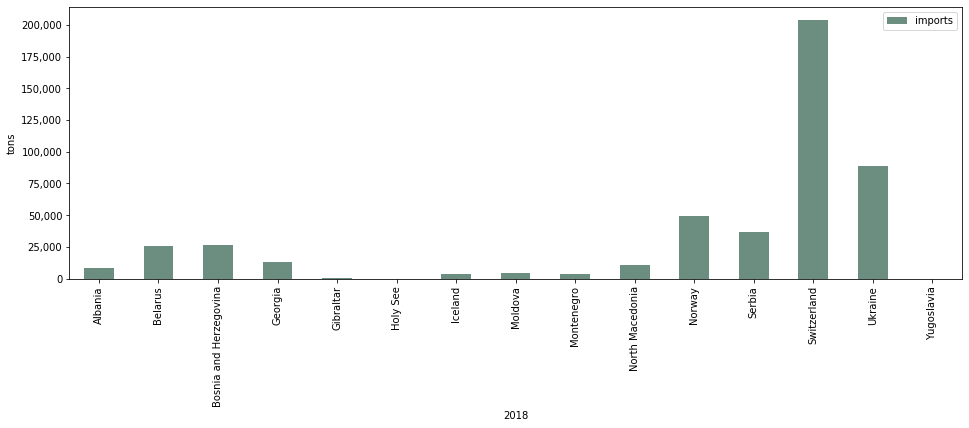

In [118]:
df = pd.read_sql("""SELECT lid.title AS location,pid.title AS parent,i.value * 66.138679 AS imports
FROM calendar_imports i
INNER JOIN location lid ON i.location_id=lid.id
INNER JOIN location pid ON lid.parent_location_id=pid.id
WHERE (year=2018 AND pid.title LIKE '%Europe%') AND NOT lid.title='EU'
ORDER BY location ASC;""",conn)
b = df.plot.bar(figsize=(16,5), color=colors_importers[1])
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['location'].tolist(), rotation=90)
b.set_ylabel("tons")
l = b.set_xlabel("2018")

There we go.  Wow, Switzerland imports a lot!

Let's turn our attention to the United States for a bit and see how many tons of coffee we have imported over the last 10 years of data.

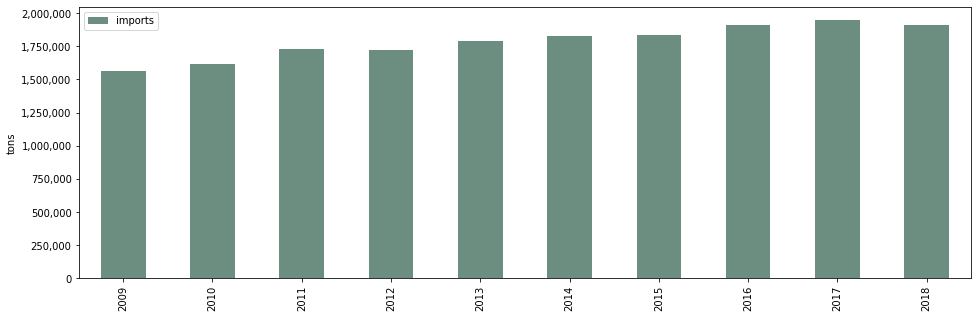

In [119]:
df = pd.read_sql("""SELECT lid.title AS location,i.year,i.value * 66.138679 AS imports
FROM calendar_imports i
INNER JOIN location lid ON i.location_id=lid.id
WHERE year>2008 AND lid.title LIKE '%USA%'
ORDER BY year ASC;""",conn)
# b = df.plot.bar(figsize=(16,5), color=colors[1])
b = df.loc[:,['imports']].plot.bar(color=colors_importers[1], figsize=(16,5))
b.set_yticklabels([f'{x:,.0f}' for x in b.get_yticks()])
b.set_xticklabels(df['year'].tolist(), rotation=90)
l = b.set_ylabel("tons")

The U.S. imports almost 10 times as much coffee as Switzerland!  Although if we think about that, we probably should have expected more.

Overall we see a steady increase in imports over the years, likely due to a growing population, although we can look into that in more detail at a later time.
<br>
<br>
<br>
Let's go ahead and add all components to the supply chain (inventory, imports, exports, consumption) and see the total coffee movement in the United States in recent years.

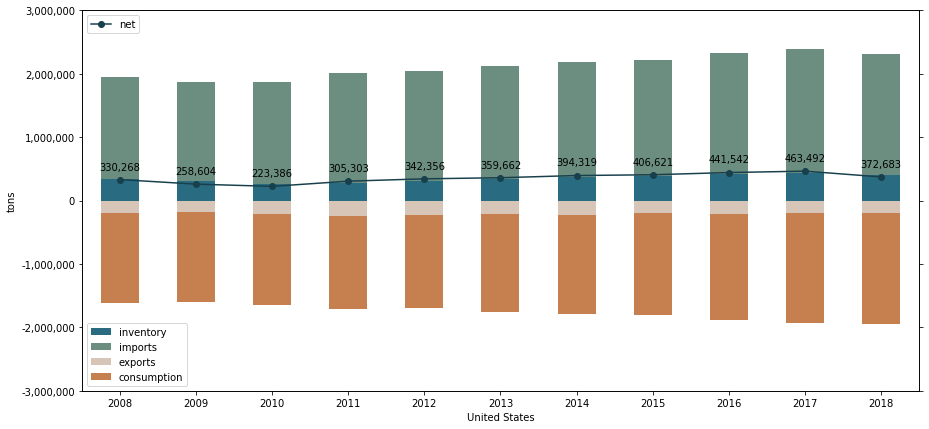

In [105]:
df = pd.read_sql("""SELECT l.title, cal3.year, cal3.inventory * 66.138679 AS inventory, cal3.imports * 66.138679 AS imports, cal3.exports * 66.138679 AS exports, cal3.consumption * 66.138679 AS consumption, (cal3.inventory + cal3.imports + cal3.exports + cal3.consumption) * 66.138679 AS net
FROM location l 
INNER JOIN
    (
        SELECT cons.location_id, cons.year, cal2.inventory, cal2.imports, cal2.exports, 
            CASE 
                WHEN cons.value > 0 THEN cons.value * -1 
            END AS consumption 
        FROM calendar_consumption cons 
        INNER JOIN
            (
                SELECT inv.location_id, inv.year, inv.value as inventory, cal.imports, cal.exports 
                FROM calendar_inventory inv 
                INNER JOIN
                    (
                        SELECT ci.location_id, ci.year, ci.value AS imports,  
                            CASE  
                                WHEN ce.value > 0 THEN ce.value * -1 
                            END AS exports 
                        FROM calendar_imports ci 
                        INNER JOIN calendar_exports ce ON ci.location_id=ce.location_id AND ci.year=ce.year
                    ) AS cal
                ON cal.location_id=inv.location_id AND inv.year=cal.year
            ) AS cal2
        ON cal2.location_id=cons.location_id AND cons.year=cal2.year
    ) AS cal3
ON cal3.location_id=l.id
WHERE l.title='USA' AND cal3.year>2007
ORDER BY cal3.year ASC;""",conn)
b1=df.loc[:,['inventory','imports','exports','consumption']].plot.bar(stacked=True, color=colors_importers, figsize=(15,7))
b1.set_xticklabels(df['year'].tolist(), rotation=0)
b1.set_yticklabels([f'{x:,.0f}' for x in b1.get_yticks()])
b1.set_ylim([min(b1.get_yticks()),max(b1.get_yticks())])
b1.legend(loc='lower left')
b1.set_ylabel("tons")
b1.set_xlabel("United States")
l1 = b1.twinx()
l1.set_yticklabels([])
l1.set_ylim([min(b1.get_yticks()),max(b1.get_yticks())])
l1.plot(b1.get_xticks(), df['net'], label='net', marker='o', color=colors_importers[4])
l1.legend(loc='upper left')
for i,x in enumerate(df['net']):
    label = f'{x:,.0f}'
    l1.annotate(label,
                (i,x),
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center

At first glance, it appears that Exports (re-Exports) barely fluctuate, and Inventory grows a bit.  Imports and Consumption grow the most, which is expected, but also points to the fact that green coffee prices in the US are likely to fluctuate a good deal since they do not have a large buffer in the form of inventory or exports to relieve some of that volatility.
<br><br><br><br>
More analysis coming soon! . . .